In [1]:
import pandas as pd

In [2]:
from scipy import stats
import math

from mplsoccer import PyPizza, add_image, FontManager
import matplotlib.pyplot as plt

In [3]:
midfield = pd.read_excel('/Users/chaniel/Desktop/Sports_Analytics/web scrapers/total.xlsx')

In [4]:
len(midfield)

2716

In [5]:
len(midfield['player'].unique())

2716

In [6]:
midfield = midfield.drop(columns='Unnamed: 0')

In [7]:
url = 'https://fbref.com/en/comps/Big5/stats/squads/Big-5-European-Leagues-Stats'

# Read the HTML table into a list of DataFrames
dfs = pd.read_html(url)

In [8]:
dfs[0].columns = ['_'.join(col) if isinstance(col, tuple) else col for col in dfs[0].columns]

In [9]:
dfs[0] = dfs[0].rename(columns={'Unnamed: 1_level_0_Squad': 'team', 'Unnamed: 5_level_0_Poss': 'poss'})

In [10]:
midfield = midfield.merge(dfs[0][['team', 'poss']], on='team', how='inner')

In [11]:
midfield.columns

Index(['player', 'position', 'nationality', 'team', 'comp_level', 'age',
       'games', 'games_starts', 'minutes', 'minutes_90s', 'goals', 'assists',
       'goals_per90', 'assists_per90', 'goals_assists_per90', 'xg', 'npxg',
       'xg_assist', 'xg_per90', 'npxg_per90', 'xg_assist_per90',
       'progressive_passes', 'progressive_carries',
       'progressive_passes_received', 'passes_completed', 'passes',
       'passes_pct', 'passes_total_distance', 'passes_progressive_distance',
       'pass_xa', 'assisted_shots', 'passes_into_final_third',
       'passes_into_penalty_area', 'crosses_into_penalty_area', 'sca',
       'sca_per90', 'sca_passes_live', 'sca_passes_dead', 'sca_take_ons',
       'sca_shots', 'sca_fouled', 'sca_defense', 'gca', 'gca_per90',
       'gca_passes_live', 'gca_passes_dead', 'gca_take_ons', 'gca_shots',
       'gca_fouled', 'gca_defense', 'touches', 'touches_def_pen_area',
       'touches_def_3rd', 'touches_mid_3rd', 'touches_att_3rd',
       'touches_att_pen_a

In [12]:
cols_convert = ['touches_live_ball','take_ons_won', 'take_ons', 'take_ons_tackled', 'carries', 'dispossessed', 'miscontrols', 'passes_blocked', 'passes_received',
               'passes', 'passes_completed', 'pass_xa', 'progressive_carries', 'progressive_passes',
                'tackles_interceptions', 'interceptions', 'tackles', 'carries_progressive_distance', 
                'passes_progressive_distance', 'passes_into_final_third', 'carries']

In [13]:
for column in cols_convert:
    new_column_name = column + '_per90'
    midfield[new_column_name] = (midfield[column] / midfield['minutes_90s']).round(2)

In [14]:
midfield['gcaper90+scaper90'] = midfield['sca_per90'] + midfield['gca_per90']

In [15]:
adj_poss = ['tackles_interceptions_per90', 'interceptions_per90', 'tackles_per90']
for c in adj_poss:
    name = c + '_adj'
    midfield[name] = midfield[c] / ((100-midfield['poss'])*50)

In [16]:
midfield['retention'] = 1-(
                            (midfield['passes_blocked_per90']
                         + midfield['dispossessed_per90']+midfield['miscontrols_per90'])/ 
                         (midfield['passes_per90']+midfield['touches_live_ball_per90'])
                        )

In [17]:
# DM / CM
# 'retention', 'interceptions', 'tackles', 'progressive passes', 'progressive carries'
# progressive pass distance , progressive carry distance , 'xA'

# AM:
# xG, xA, gcaper90+scaper90, 'take_ons_won', 'progressive carries', 'progressive passes', 'tackles_interception', 'retention'


In [18]:
modified_column_names = []
for col in midfield.columns:
    modified_col = col.replace('_', ' ')
    modified_column_names.append(modified_col)


In [19]:
midfield.columns = modified_column_names

In [20]:
params_dec = ['retention', 'interceptions per90 adj', 'tackles per90 adj',
             'progressive passes per90', 'progressive carries per90', 'carries progressive distance per90',
             'passes progressive distance per90', 'pass xa per90']
params_mount = ['retention', 'xg per90', 'pass xa per90', 'gcaper90+scaper90', 'progressive passes per90', 
                'progressive carries per90', 'tackles interceptions per90 adj', 'passes into final third per90']

In [21]:
midfield['position'].unique()

array(['MF,FW', 'MF', 'DF', 'FW', 'FW,MF', 'GK', 'MF,DF', 'DF,MF',
       'FW,DF', 'DF,FW'], dtype=object)

In [22]:
midfield_10 = midfield[(midfield['position'].isin(['MF,FW'])) & (pd.to_numeric(midfield['minutes 90s']) >= 13)]

In [23]:
midfield_cm = midfield[(midfield['position'].isin(['MF'])) & (pd.to_numeric(midfield['minutes 90s']) >= 13)]

In [24]:
def make_pizza(vals, metrics, df, color, caps):
    list_vals = list(vals.iloc[0])
    # calculate percentiles
    values = []
    for x in range(len(metrics)):
        values.append(math.floor(stats.percentileofscore(df[metrics[x]], list_vals[x])))
    
    for n,i in enumerate(values):
        if i == 100:
            values[n] = 99
            
    baker = PyPizza(
        params=metrics,                  # list of parameters
        straight_line_color="#000000",  # color for straight lines
        straight_line_lw=1,             # linewidth for straight lines
        last_circle_lw=2,               # linewidth of last circle
        other_circle_lw=1,              # linewidth for other circles
        other_circle_ls="-.",           # linestyle for other circles
        background_color="#000000",
        last_circle_color="#FFFFFF"
    
    )
    
    # plot pizza
    fig, ax = baker.make_pizza(
        values,              # list of values
        figsize=(8, 8),      # adjust figsize according to your need
        param_location=110,  # where the parameters will be added
        kwargs_slices=dict(
            facecolor=color[0], edgecolor="#000000",
            zorder=2, linewidth=1
        ),                   # values to be used when plotting slices
        kwargs_params=dict(
            color="#FFFFFF", fontsize=12,
            va="center", alpha=0.9
        ),                   # values to be used when adding parameter
        kwargs_values=dict(
            color=color[1], fontsize=12,
            zorder=3,
            bbox=dict(
                edgecolor="#000000", facecolor=color[0],
                boxstyle="round,pad=0.2", lw=1
            )
        )                    # values to be used when adding parameter-values
    )

    # add title
    fig.text(
        0.515, 0.97, caps[0] , size=18,
        ha="center", color="#FFFFFF"
    )

    # add subtitle
    fig.text(
        0.515, 0.942,
        caps[1],
        size=15,
        ha="center", color="#FFFFFF"
    )

    # add credits
    #notes = caps[2]
    #CREDIT_1 = "data: statsbomb via fbref"
    #CREDIT_2 = "inspired by: @Worville, @FootballSlices, @somazerofc & @Soumyaj15209314"

    #fig.text(
     #   0.99, 0.005, f"{notes}\n{CREDIT_1}\n{CREDIT_2}", size=9,
      #  color="#FFFFFF",
       # ha="right"
    #)
    
    fig.savefig(fname=caps[0], bbox_inches='tight', dpi=200, facecolor='#000000')
    return values

In [25]:
mount = midfield_10[midfield_10['player']=='Mason Mount'][params_mount]
dec = midfield_cm[midfield_cm['player']=='Declan Rice'][params_dec]

In [183]:
colors = ["#7A263A", '#FFFFFF']

In [27]:
captions_m = ["Mason Mount - Manchester United","Per 90 Percentile Rank vs Attacking Midfielders in Top Five Leagues with more than 13 90s| 2022-23"]
captions_d = ["Declan Rice - Arsenal","Per 90 Percentile Rank vs Central Midfielders in Top Five Leagues with more than 13 90s| 2022-23"]

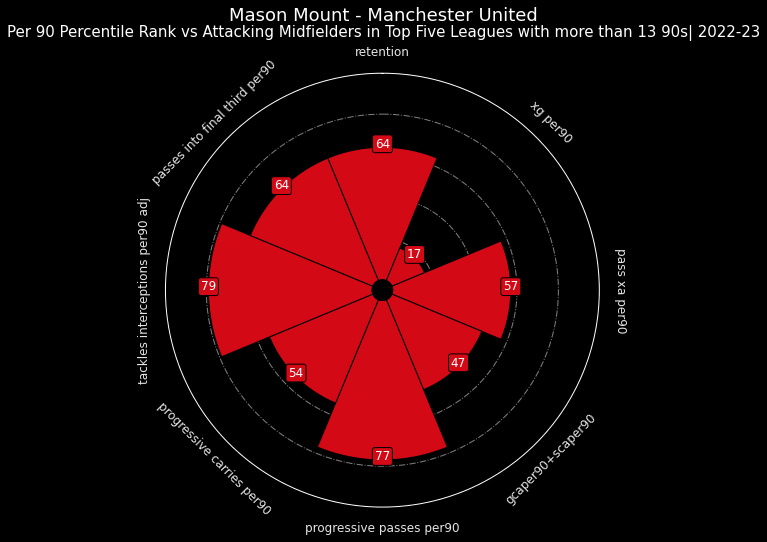

In [28]:
mount_v = make_pizza(mount, params_mount, midfield_10, colors, captions_m)

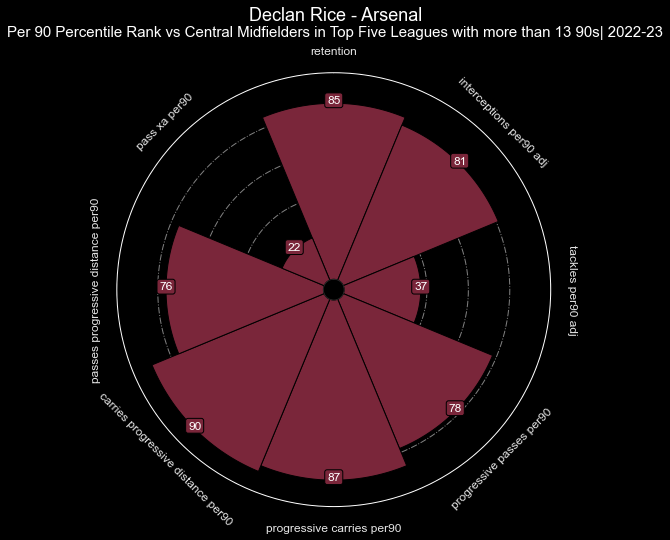

In [184]:
dec_v = make_pizza(dec, params_dec, midfield_cm, colors, captions_d)

In [176]:
def distribution_chart(data, p, pl, name, c, title):
    import seaborn as sns
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import zscore
    sns.set_style("white")
    import warnings
    warnings.filterwarnings('ignore') 
    
    d=data[p]
    z_scores = d.apply(zscore)
    z_scores_df = pd.DataFrame(z_scores, columns=d.columns)
    z_scores_df['player'] = np.array(pl)
    scores = z_scores_df[z_scores_df['player']==name]
    
    fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(16, 10))
    axes = axes.flatten()
    vals = scores.values[0][:-1]
    labels = data[data.player==name][p].values[0].round(3)
    
    for i, column in enumerate(z_scores_df.columns[:-1]):
   
        sns.kdeplot(z_scores_df[column], ax=axes[i], color=c, fill=True,alpha=0.7)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['bottom'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        axes[i].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
        axes[i].set_xticklabels([])
        axes[i].set_yticklabels([])
        axes[i].axvline(vals[i], color='white', linestyle='solid', linewidth=1)
        axes[i].axvline(1, color='black', linestyle='-', linewidth=1)
        axes[i].axvline(-1, color='black', linestyle='-', linewidth=1)


    for i, column in enumerate(z_scores_df.columns[:-1]):
        axes[i].text(min(z_scores_df[column])-((max(z_scores_df[column])-min(z_scores_df[column]))/3), 0.05, f'{column}', color=c, ha='right', va='bottom', fontsize=12.1)
        axes[i].text(max(z_scores_df[column])+((max(z_scores_df[column])-min(z_scores_df[column]))/6), 0.05, f'{labels[i]}', color=c, ha='right', va='bottom', fontsize=12.1)

    plt.annotate("Per 90' Number",
                     xy = (.85, 9), xycoords='axes fraction',
                    ha='left', va='center',
                    fontsize=12.1, 
                    color="#4A2E19"
                    )  
    plt.annotate("Metric",
                     xy = (0, 9), xycoords='axes fraction',
                    ha='left', va='center',
                    fontsize=12.1, 
                    color="#4A2E19"
                    ) 
    plt.annotate(title,
                     xy = (0.5, 10), xycoords='axes fraction',
                    ha='center', va='center',
                    fontsize=18, 
                    color="#4A2E19"
                    ) 
    fig.savefig(fname=title, bbox_inches='tight', dpi=200, facecolor='#FFFFFF')
    plt.tight_layout()
    plt.show()

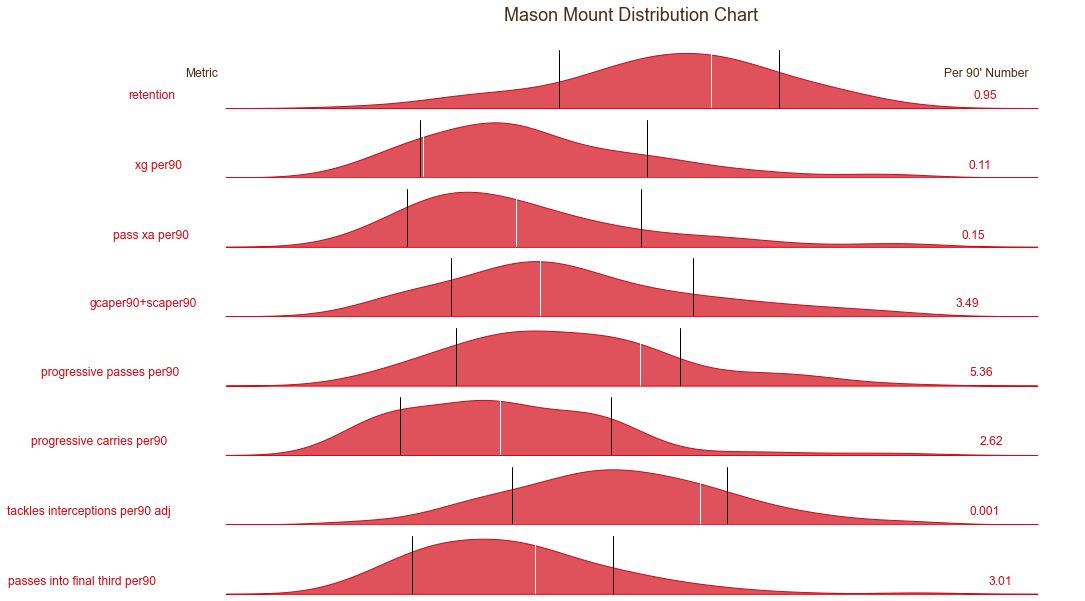

In [177]:
distribution_chart(midfield_10, params_mount, midfield_10['player'], 'Mason Mount', '#D30915', 'Mason Mount Distribution Chart')

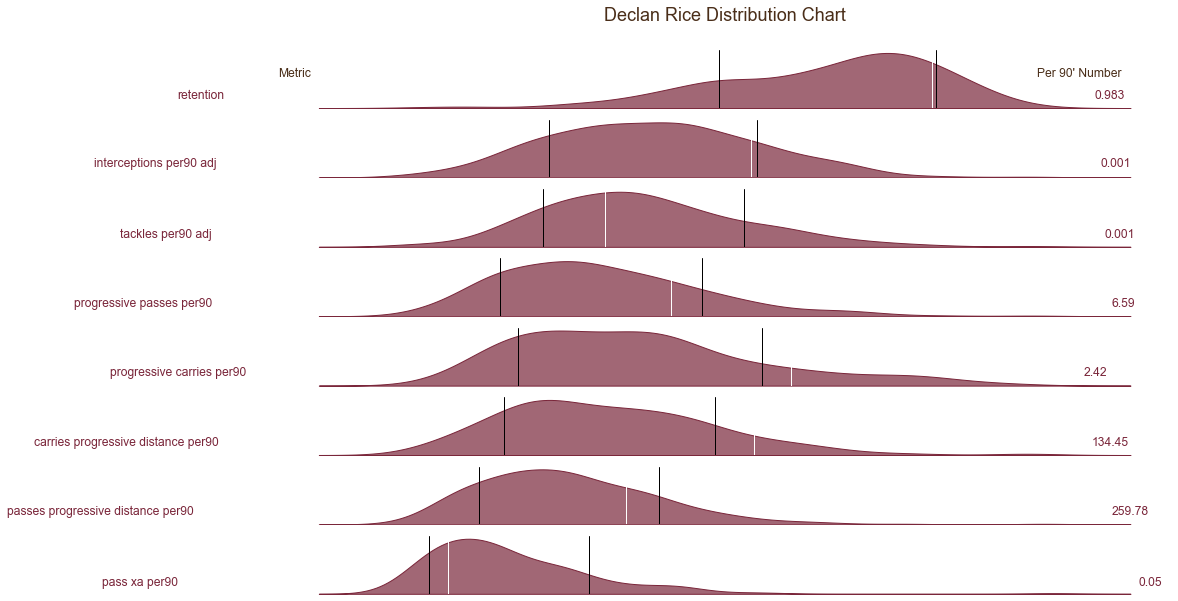

In [185]:
distribution_chart(midfield_cm, params_dec, midfield_cm['player'], 'Declan Rice', '#7A263A', 'Declan Rice Distribution Chart')